# Physics-informed neural networks for characterization of metamaterials

In [1]:
import sys
sys.path.insert(1, '../PINNLearning')

from training import learning_rate_schedule, train, simp_loss
from data import gen_data, set_boundaries, simp_sol
from models import create_model
import matplotlib.pyplot as plt
import keras

2025-05-25 18:39:24.667554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We first need to set some global values and settings:

In [2]:
plt.close('all')
plt.rcParams['font.family'] = 'Ubuntu Nerd Font'
plt.rcParams['font.size'] = 10


lower_bound = 0.0
upper_bound = 1.0

## Initial Testing

First we try the simplified function:

$u(x) = \dfrac{d^2}{dx^2} u(x)$

With the boundary conditions set to:

$u(0) = 1$ and $u(1) = 0$

The analytical solution for this equation should be:

$u(x) = \dfrac{e^{-x} (e^2-e^{2x})}{e^2-1}$

For learning the Model, first the boundary conditions need to be set as tensors. Then the trainings data needs to be generated and finally, the model needs to be created. 

In this implementation here I check if the model is already trained in 'data'. If this is the case, the training will be suspendend. Otherwise the model will be automatically trained and a graph will be printed of how the loss developed with respect to the number of epochs.

Epoch 100: Loss = 0.004858677741140127
Epoch 200: Loss = 0.0008453191840089858
Epoch 300: Loss = 0.0005726620438508689
Epoch 400: Loss = 0.00038555412902496755
Epoch 500: Loss = 0.0003011305525433272
Epoch 600: Loss = 0.0001952258899109438
Epoch 700: Loss = 0.00014513962378259748
Epoch 800: Loss = 0.00010349836520617828
Epoch 900: Loss = 8.091581548796967e-05
Epoch 1000: Loss = 6.463575118687004e-05
Last Epoch 1045: last Loss = 5.9737329138442874e-05


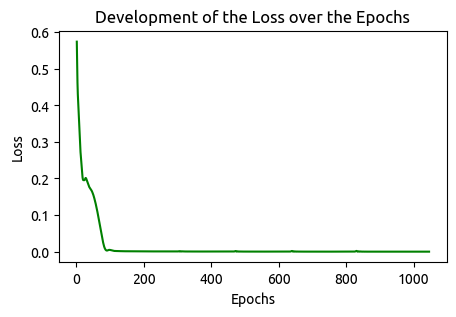

In [3]:
# Set the boundary conditions
x_bc, y_bc = set_boundaries([[0.0], [1.0]], [[1.0], [0.0]])

# create the training data
x_train = gen_data(lower_bound, upper_bound, 100)

# create the model with fixed sizes
model = create_model(3, 50)

# create the learning rate schedule
lr_schedule = learning_rate_schedule(1e-3, 1000, 0.9)

# Train the model if it is not already trained
try:
    model = keras.models.load_model('../data/simp_initial.keras')
except Exception as e:
    error_time = train(model, x_train, x_bc, y_bc, lr_schedule, threshold=1e-8)
    model.save('../data/simp_initial.keras')

    # create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Development of the Loss over the Epochs')
    plt.show()

When the model is finished training, it needs to be tested against the analytical solution. For this, another dataset of test points is created and the analytical solution as well as the PINN are inferenced accorss these points. A graphical comparison is presented below.

The loss over the validation data is: 5.5960208555916324e-05


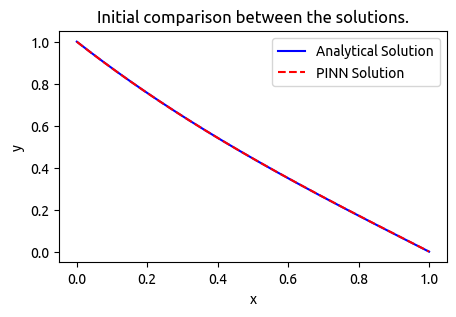

In [4]:
x_test = gen_data(lower_bound, upper_bound, 1000)

# Calculate the loss over the test data
val_loss = simp_loss(model, x_test, x_bc, y_bc)
print(f"The loss over the validation data is: {val_loss}")

y_pred = model(x_test).numpy()
y_true = simp_sol(x_test)

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial comparison between the solutions.')
plt.show()